<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Post-proc-df" data-toc-modified-id="Post-proc-df-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Post proc df</a></span></li><li><span><a href="#proc_df" data-toc-modified-id="proc_df-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>proc_df</a></span></li></ul></div>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 4
%autosave 120

Autosaving every 120 seconds


In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.torch_imports import *
from fastai.dataset import *
from fastai.learner import *
from fastai.structured import *
from fastai.column_data import *
import feather
import gc

In [6]:
df_raw = feather.read_dataframe('all_train_cont')
# df_test = feather.read_dataframe('all_test_cont')

In [7]:
dep = 'target'

In [8]:
for df in [df_raw]:
    df.drop('price', axis=1, inplace=True)
    df.drop('purchase_amount_sum_ratio', axis=1, inplace=True)
    df.drop('installments_ratio', axis=1, inplace=True)
    df.drop('month_diff_ratio', axis=1, inplace=True)
    for f in ['purchase_date']:
        df[f] = df[f].astype(np.int64) * 1e-9
    for c in ['avg_purchases_lag3', 'avg_purchases_lag6', 'avg_purchases_lag12']:
        df[c] = df[c].replace(np.inf, df[c].median())

In [9]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [10]:
df_raw = reduce_mem_usage(df_raw)

Mem. usage decreased to 3127.28 Mb (43.5% reduction)


In [6]:
train_cards = df_raw['card_id'].unique()

In [7]:
train_cards.shape

(201917,)

In [8]:
val_cards = np.random.choice(train_cards, 40000)

In [9]:
val_cards.shape

(40000,)

In [10]:
val_idx = df_raw.index[df_raw.card_id.isin(val_cards)]

In [11]:
val_cards2 = np.random.choice(val_cards, 8000)

In [12]:
df_valid = df_raw.iloc[val_idx]

In [13]:
val_idx2 = df_valid.index[df_valid.card_id.isin(val_cards2)]

In [14]:
df_raw.shape, df_valid.shape, len(val_idx2)

((19249698, 91), (3433782, 91), 678088)

In [15]:
df_valid_trn = df_valid[~df_valid.card_id.isin(val_cards2)]

In [16]:
df_valid_trn.shape, df_valid.shape, len(val_idx2)

((2755694, 91), (3433782, 91), 678088)

In [11]:
gc.collect()

19

In [18]:
val_idx.shape

(3433782,)

In [16]:
trn_idx = df_raw[~df_raw.card_id.isin(val_cards)]

MemoryError: 

In [19]:
val_idx.shape, trn_idx.shape, df_raw.shape

NameError: name 'trn_idx' is not defined

In [18]:
df_raw.columns.values

array(['authorized_flag', 'card_id', 'installments', 'category_3', 'merchant_category_id', 'merchant_id',
       'month_lag', 'purchase_amount', 'purchase_date', 'purchase_Year', 'purchase_Month', 'purchase_Week',
       'purchase_Day', 'purchase_Dayofweek', 'purchase_Dayofyear', 'purchase_Is_month_end',
       'purchase_Is_month_start', 'purchase_Is_quarter_end', 'purchase_Is_quarter_start',
       'purchase_Is_year_end', 'purchase_Is_year_start', 'purchase_Hour', 'purchase_Minute',
       'purchase_Second', 'purchase_Elapsed', 'purchased_on_weekend', 'purchased_on_weekday', 'month_diff',
       'purchase_date_successive_diff', 'Christmas_Day_2017', 'Mothers_Day_2017', 'fathers_day_2017',
       'Children_day_2017', 'Valentine_Day_2017', 'Black_Friday_2017', 'Mothers_Day_2018', 'duration',
       'amount_month_ratio', 'merchant_address_id', 'numerical_range', 'merchant_rating',
       'merchant_group_id', 'merchant_category_id_y', 'subsector_id', 'numerical_1', 'numerical_2',
       '

In [57]:
pd.set_option('display.max_rows', 100)

In [13]:
df_raw.dtypes

authorized_flag                  category
card_id                            object
installments                      float64
category_3                       category
merchant_category_id             category
merchant_id                        object
month_lag                           int64
purchase_amount                   float64
purchase_date                     float64
purchase_Year                    category
purchase_Month                   category
purchase_Week                    category
purchase_Day                     category
purchase_Dayofweek               category
purchase_Dayofyear               category
purchase_Is_month_end                bool
purchase_Is_month_start              bool
purchase_Is_quarter_end              bool
purchase_Is_quarter_start            bool
purchase_Is_year_end                 bool
purchase_Is_year_start               bool
purchase_Hour                    category
purchase_Minute                  category
purchase_Second                  c

In [8]:
df_raw.select_dtypes(include=['category']).columns.values

array(['authorized_flag', 'category_3', 'merchant_category_id', 'purchase_Year', 'purchase_Month',
       'purchase_Week', 'purchase_Day', 'purchase_Dayofweek', 'purchase_Dayofyear', 'purchase_Hour',
       'purchase_Minute', 'purchase_Second', 'purchased_on_weekend', 'purchased_on_weekday',
       'Christmas_Day_2017', 'Mothers_Day_2017', 'fathers_day_2017', 'Children_day_2017',
       'Valentine_Day_2017', 'Black_Friday_2017', 'Mothers_Day_2018', 'merchant_rating', 'merchant_group_id',
       'subsector_id', 'category_1', 'most_recent_sales_range', 'most_recent_purchases_range',
       'active_months_lag3', 'active_months_lag6', 'active_months_lag12', 'category_4', 'city_id',
       'state_id', 'category_2', 'days_feature1', 'days_feature1_ratio', 'days_feature2',
       'days_feature2_ratio', 'days_feature3', 'days_feature3_ratio', 'feature_1', 'feature_2', 'feature_3',
       'feature_max', 'feature_mean', 'feature_min', 'feature_sum', 'feature_var', 'hist_first_buy',
       'hist_

In [8]:
df_test.select_dtypes(include=['category']).columns.values

array(['authorized_flag', 'category_3', 'merchant_category_id', 'purchase_Year', 'purchase_Month',
       'purchase_Week', 'purchase_Day', 'purchase_Dayofweek', 'purchase_Dayofyear', 'purchase_Hour',
       'purchase_Minute', 'purchase_Second', 'purchased_on_weekend', 'purchased_on_weekday',
       'Christmas_Day_2017', 'Mothers_Day_2017', 'fathers_day_2017', 'Children_day_2017',
       'Valentine_Day_2017', 'Black_Friday_2017', 'Mothers_Day_2018', 'merchant_rating', 'merchant_group_id',
       'subsector_id', 'category_1', 'most_recent_sales_range', 'most_recent_purchases_range',
       'active_months_lag3', 'active_months_lag6', 'active_months_lag12', 'category_4', 'city_id',
       'state_id', 'category_2', 'days_feature1', 'days_feature1_ratio', 'days_feature2',
       'days_feature2_ratio', 'days_feature3', 'days_feature3_ratio', 'feature_1', 'feature_2', 'feature_3',
       'feature_max', 'feature_mean', 'feature_min', 'feature_sum', 'feature_var', 'hist_first_buy',
       'hist_

In [12]:
cat_flds = df_raw.select_dtypes(include=['category']).columns.values

In [13]:
cat_flds = cat_flds.tolist() + ['card_id', 'merchant_id', 'merchant_address_id']

In [14]:
gc.collect()

0

In [29]:
pd.set_option('display.max_rows', 100)

In [23]:
df_raw.head().T

,0,1,2,3,4
authorized_flag,1,1,1,0,1
card_id,C_ID_da2090f28e,C_ID_efced389a0,C_ID_479fd6392a,C_ID_79296614ed,C_ID_f43ae18887
installments,0,1,1,0,0
category_3,0,1,1,0,0
merchant_category_id,623,842,839,360,511
merchant_id,M_ID_f001319a61,M_ID_18038b5ae7,M_ID_e5374dabc0,M_ID_257157f6ee,M_ID_00a6ca8a8a
month_lag,-11,-12,-1,-3,-13
purchase_amount,40,120,6,108.5,39
purchase_date,1.48323e+09,1.48323e+09,1.48323e+09,1.48323e+09,1.48323e+09
purchase_Year,2017,2017,2017,2017,2017


In [14]:
df_raw.shape, df_test.shape

((19249698, 91), (11825701, 91))

In [15]:
bool_flds = df_raw.select_dtypes(include=['bool']).columns.values

In [16]:
cat_flds = cat_flds + bool_flds.tolist()

In [17]:
cont_flds = [n for n in df_raw.columns if n not in cat_flds and n!= 'outliers']

In [18]:
gc.collect()

0

In [15]:
# %%time
# df_raw = df_raw[cat_flds+cont_flds]
# df, y, nas, mapper_t = proc_df(df_raw, 'target', do_scale=True)

In [19]:
for c in bool_flds:
    df_raw[c] = df_raw[c].astype('category')

In [17]:
[n for n in df_raw.drop(cat_flds,axis=1).columns if not is_numeric_dtype(df_raw[n])]

[]

In [20]:
for c in cat_flds: df_raw[c] = df_raw[c].astype('category')

In [21]:
gc.collect()

0

In [22]:
df_raw = df_raw[cat_flds+cont_flds]

In [23]:
df_raw = reduce_mem_usage(df_raw)

/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

Mem. usage decreased to 2924.95 Mb (0.0% reduction)


In [28]:
cont_flds

['installments',
 'month_lag',
 'purchase_amount',
 'purchase_date',
 'purchase_Elapsed',
 'month_diff',
 'purchase_date_successive_diff',
 'duration',
 'amount_month_ratio',
 'numerical_range',
 'merchant_category_id_y',
 'numerical_1',
 'numerical_2',
 'avg_sales_lag3',
 'avg_purchases_lag3',
 'avg_sales_lag6',
 'avg_purchases_lag6',
 'avg_sales_lag12',
 'avg_purchases_lag12',
 'CLV',
 'CLV_old',
 'CLV_ratio',
 'card_id_count_ratio',
 'target']

In [29]:
for df in [df_raw]:
    df.drop('CLV', axis=1, inplace=True)
    df.drop('CLV_old', axis=1, inplace=True)
    df.drop('card_id_count_ratio', axis=1, inplace=True)
    df.drop('amount_month_ratio', axis=1, inplace=True)

In [31]:
for df in [df_raw]:
    df.drop('CLV_ratio', axis=1, inplace=True)

In [34]:
gc.collect()

0

In [35]:
%%time
df, y, nas, mapper_t = proc_df(df_raw, 'target', do_scale=True)

/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keep

CPU times: user 2min 32s, sys: 18.8 s, total: 2min 51s
Wall time: 1min 32s


In [36]:
df.shape

(19249698, 82)

In [37]:
gc.collect()

48

In [39]:
df.dtypes

authorized_flag                     int8
category_3                          int8
merchant_category_id               int16
purchase_Year                       int8
purchase_Month                      int8
purchase_Week                       int8
purchase_Day                        int8
purchase_Dayofweek                  int8
purchase_Dayofyear                 int16
purchase_Hour                       int8
purchase_Minute                     int8
purchase_Second                     int8
purchased_on_weekend                int8
purchased_on_weekday                int8
Christmas_Day_2017                  int8
Mothers_Day_2017                    int8
fathers_day_2017                    int8
Children_day_2017                   int8
Valentine_Day_2017                  int8
Black_Friday_2017                   int8
Mothers_Day_2018                    int8
merchant_rating                     int8
merchant_group_id                  int64
subsector_id                        int8
category_1      

In [40]:
df.to_feather('df_cont_proc')

### Post proc df

In [41]:
df = reduce_mem_usage(df)

Mem. usage decreased to 3102.49 Mb (34.2% reduction)


In [46]:
train_cards = df['card_id'].unique()

In [47]:
train_cards.shape

(201917,)

In [48]:
val_cards = np.random.choice(train_cards, 40000)

In [49]:
val_idx = df.index[df.card_id.isin(val_cards)]

In [51]:
y.shape

(19249698,)

In [32]:
y_val = df_valid['target']

### proc_df

In [52]:
# df_sorted = df_valid.sort_values(['card_id', 'purchase_date'])

In [53]:
# df_sorted.reset_index(inplace=True)

In [54]:
# df_sorted.drop('index', axis=1, inplace=True)

In [55]:
# df_valid.shape, df_sorted.shape

In [35]:
%%time
df,y, nas, mapper_t = proc_df(df_sorted, 'target', do_scale=True)

CPU times: user 1min, sys: 3.28 s, total: 1min 4s
Wall time: 20.3 s


In [56]:
gc.collect()

748

In [27]:
%%time
df_test_copy = df_test[cat_flds+cont_flds+[dep]].copy()
df_t, _, nas, mapper = proc_df(df_test_copy,'target', do_scale=True, mapper=mapper_t)

NameError: name 'mapper_t' is not defined

In [57]:
df.shape

(19249698, 82)

In [58]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

In [62]:
emb_c = {n: len(c.cat.categories)+1 for n,c in df_raw[cat_flds].items()}
emb_c

{'authorized_flag': 3,
 'category_3': 4,
 'merchant_category_id': 328,
 'purchase_Year': 3,
 'purchase_Month': 13,
 'purchase_Week': 53,
 'purchase_Day': 32,
 'purchase_Dayofweek': 8,
 'purchase_Dayofyear': 366,
 'purchase_Hour': 25,
 'purchase_Minute': 61,
 'purchase_Second': 61,
 'purchased_on_weekend': 3,
 'purchased_on_weekday': 3,
 'Christmas_Day_2017': 101,
 'Mothers_Day_2017': 101,
 'fathers_day_2017': 101,
 'Children_day_2017': 101,
 'Valentine_Day_2017': 101,
 'Black_Friday_2017': 101,
 'Mothers_Day_2018': 29,
 'merchant_rating': 17,
 'merchant_group_id': 109392,
 'subsector_id': 42,
 'category_1': 3,
 'most_recent_sales_range': 6,
 'most_recent_purchases_range': 6,
 'active_months_lag3': 4,
 'active_months_lag6': 7,
 'active_months_lag12': 13,
 'category_4': 3,
 'city_id': 272,
 'state_id': 26,
 'category_2': 6,
 'days_feature1': 644,
 'days_feature1_ratio': 647,
 'days_feature2': 488,
 'days_feature2_ratio': 505,
 'days_feature3': 233,
 'days_feature3_ratio': 234,
 'feature_

In [63]:
emb_szs = [(c, min(30, (c+1)//2)) for _,c in emb_c.items()]
metrics=[rmse]

In [64]:
y_range=(np.min(y)*1,np.max(y))

In [65]:
emb_szs

[(3, 2),
 (4, 2),
 (328, 30),
 (3, 2),
 (13, 7),
 (53, 27),
 (32, 16),
 (8, 4),
 (366, 30),
 (25, 13),
 (61, 30),
 (61, 30),
 (3, 2),
 (3, 2),
 (101, 30),
 (101, 30),
 (101, 30),
 (101, 30),
 (101, 30),
 (101, 30),
 (29, 15),
 (17, 9),
 (109392, 30),
 (42, 21),
 (3, 2),
 (6, 3),
 (6, 3),
 (4, 2),
 (7, 4),
 (13, 7),
 (3, 2),
 (272, 30),
 (26, 13),
 (6, 3),
 (644, 30),
 (647, 30),
 (488, 30),
 (505, 30),
 (233, 30),
 (234, 30),
 (6, 3),
 (4, 2),
 (3, 2),
 (6, 3),
 (8, 4),
 (3, 2),
 (8, 4),
 (10, 5),
 (2005, 30),
 (1955, 30),
 (1963, 30),
 (1991, 30),
 (233, 30),
 (5, 3),
 (201918, 30),
 (313542, 30),
 (313543, 30),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2)]

In [66]:
len(cat_flds), len(cont_flds), len(df.columns)

(63, 24, 82)

In [67]:
df.shape

(19249698, 82)

In [47]:
df[643378:643395]

,authorized_flag,card_id,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,purchase_Year,...,hist_last_buy,installments_ratio,month_diff_ratio,new_first_buy,new_last_buy,observed_elapsed_time,outliers,purchase_amount_sum_ratio,quarter,installments_na
643378,2,6769,0.295405,2,269,164944,1.091061,-0.000064,0.767393,1,...,195,0.026446,-0.749105,168,190,23,-0.102886,-0.217039,2,-0.086818
643379,2,6769,1.999314,3,321,526,1.091061,-0.002828,0.801695,1,...,195,0.026446,-0.749105,168,190,23,-0.102886,-0.217039,2,-0.086818
643380,2,6769,0.295405,2,263,183722,1.091061,-0.003234,0.802041,1,...,195,0.026446,-0.749105,168,190,23,-0.102886,-0.217039,2,-0.086818
643381,2,6769,0.295405,2,86,83008,1.091061,-0.003209,0.807492,1,...,195,0.026446,-0.749105,168,190,23,-0.102886,-0.217039,2,-0.086818
643382,1,6769,0.295405,2,282,55457,1.091061,-0.003539,0.811787,1,...,195,0.026446,-0.749105,168,190,23,-0.102886,-0.217039,2,-0.086818
643383,2,6769,0.295405,2,282,55457,1.091061,-0.003539,0.811813,1,...,195,0.026446,-0.749105,168,190,23,-0.102886,-0.217039,2,-0.086818
643384,2,6769,0.295405,2,28,169141,1.091061,-0.003311,0.833055,1,...,195,0.026446,-0.749105,168,190,23,-0.102886,-0.217039,2,-0.086818
643385,2,6769,0.295405,2,269,131376,1.091061,-0.001745,0.833306,1,...,195,0.026446,-0.749105,168,190,23,-0.102886,-0.217039,2,-0.086818
643386,2,6769,-0.556550,1,8,115522,1.091061,-0.003281,0.842458,1,...,195,0.026446,-0.749105,168,190,23,-0.102886,-0.217039,2,11.518360
643387,2,6769,0.295405,2,160,178958,1.091061,-0.003539,0.848663,1,...,195,0.026446,-0.749105,168,190,23,-0.102886,-0.217039,2,-0.086818


In [48]:
val_idx2 = list(range(0, 643395))

In [49]:
len(val_idx2)

643395

In [50]:
gc.collect()

1874

In [54]:
len(val_idx2), df.shape, y.shape

(643395, (3433782, 91), (3433782,))

In [52]:
len(np.unique(df.columns.values))

91

In [75]:
gc.collect()

0

In [73]:
df.shape, val_idx.shape

((19249698, 82), (3456857,))

In [76]:
md = ColumnarModelData.from_data_frame('./', val_idx, df, y.astype(np.float32), cat_flds=cat_flds, bs=1024, test_df=df[:1000])

In [77]:
gc.collect()

42

In [78]:
%%time
m = md.get_learner(emb_szs, len(df.columns)-len(cat_flds),
                   0.4, 1, [500, 250], [0.1, 0.01], y_range=y_range)

CPU times: user 2.21 s, sys: 492 ms, total: 2.71 s
Wall time: 3.15 s


In [79]:
m.lr_find()

 95%|█████████▌| 14721/15423 [07:45<00:22, 30.56it/s, loss=41.7]

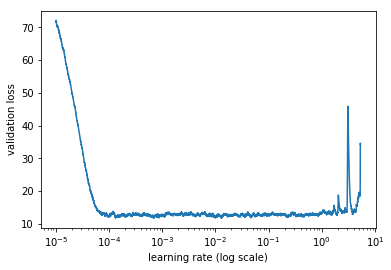

In [80]:
m.sched.plot()

In [81]:
lr=5e-5; wd=1e-6

In [82]:
%time m.fit(lr, 1, cycle_len=2, cycle_mult=2, metrics=[rmse])

epoch      trn_loss   val_loss   rmse                           
    0      13.28498   13.348087  3.4782    
    1      12.876462  13.348195  3.477882                       
CPU times: user 14min, sys: 3min 10s, total: 17min 10s
Wall time: 16min 28s


[array([13.3482]), 3.4778819355627983]

In [83]:
l = m.predict()

In [84]:
l.shape

(3456857, 1)

In [93]:
df_true_val = df_raw.iloc[val_idx]

In [94]:
df_true_val.shape

(3456857, 82)

In [95]:
df_true_val['target_new'] = l

/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [96]:
df_true_val[['target', 'target_new']].head()

,target,target_new
1,-1.839844,-0.455933
7,-33.218750,-0.455933
10,-1.161133,-0.455933
14,0.290527,-0.455933
15,1.162109,-0.455933


In [100]:
l

array([[-0.45593],
       [-0.45593],
       [-0.45593],
       ...,
       [-0.45593],
       [-0.45593],
       [-0.45593]], dtype=float32)

In [98]:
df_true_val.groupby(['card_id']).agg({'target': ['mean'], 'target_new': ['mean']})

,target,target_new
,mean,mean
card_id,,
C_ID_00007093c1,NaN,NaN
C_ID_0001506ef0,0.884277,-0.455933
C_ID_000183fdda,NaN,NaN
C_ID_00027503e2,NaN,NaN
C_ID_0002c7c2c1,NaN,NaN
C_ID_0003be3c83,-0.083252,-0.455933
C_ID_00042d509c,NaN,NaN
C_ID_0004888ddd,NaN,NaN


In [97]:
len(val_idx)

3456857

In [66]:
l_t = m.predict(is_test=True)

In [72]:
l_t.shape, l.shape, df_valid.shape

((3433782, 1), (643395, 1), (3433782, 91))

In [75]:
df_valid['target_new'] = l_t

/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [77]:
df_valid[['card_id', 'target', 'target_new']].head()

,card_id,target,target_new
1,C_ID_efced389a0,-1.840332,0.658630
5,C_ID_ecf77791d8,-1.065921,1.004230
6,C_ID_a24df943dd,3.130923,0.989231
15,C_ID_ce778b86f8,1.162205,0.969341
18,C_ID_7ba7751d53,0.679358,0.706181


In [96]:
df_haa = df_valid.groupby('card_id').agg({'target': ['median'], 'target_new': ['median']})

In [97]:
df_haa.columns = ['_'.join(c) for c in df_haa.columns.values]

In [98]:
gc.collect()

28

In [99]:
rmse(df_haa.target_median.values, df_haa.target_new_median.values)

3.9617159691277544

In [100]:
df_haa.head()

,target_median,target_new_median
card_id,,
C_ID_0005b2f279,2.945304,-1.311934
C_ID_0005b5804f,0.685599,-1.000813
C_ID_0007a60a33,-1.614517,-1.164612
C_ID_000844d8f1,-0.868258,-1.182117
C_ID_000a6044e9,-3.774958,-1.102848


In [101]:
df_vla = df_sorted[:643395]

In [102]:
df_vla.shape, l.shape

((643395, 91), (643395, 1))

In [103]:
df_vla['target_pred'] = l

/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [104]:
df_vla.head()

,authorized_flag,card_id,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,purchase_Year,...,installments_ratio,month_diff_ratio,new_first_buy,new_last_buy,observed_elapsed_time,outliers,purchase_amount_sum_ratio,quarter,target,target_pred
0,1,C_ID_0005b2f279,1.0,1,818,M_ID_431d369269,-11,106.0,1.485686e+09,2017,...,0.040816,1.001172,NaN,NaN,NaN,0,0.071279,2.0,2.945304,0.658630
1,1,C_ID_0005b2f279,1.0,1,278,M_ID_f064c2a380,-11,62.9,1.485695e+09,2017,...,0.040816,1.001172,NaN,NaN,NaN,0,0.071279,2.0,2.945304,1.004230
2,1,C_ID_0005b2f279,1.0,1,307,M_ID_256a900ace,-10,100.0,1.486204e+09,2017,...,0.040816,1.001172,NaN,NaN,NaN,0,0.071279,2.0,2.945304,0.989231
3,1,C_ID_0005b2f279,1.0,1,842,M_ID_30be6cf889,-7,38.0,1.494040e+09,2017,...,0.040816,1.001172,NaN,NaN,NaN,0,0.071279,2.0,2.945304,0.969341
4,1,C_ID_0005b2f279,1.0,1,278,M_ID_8c0ebe57c6,-7,30.0,1.495985e+09,2017,...,0.040816,1.001172,NaN,NaN,NaN,0,0.071279,2.0,2.945304,0.706181


In [120]:
df_lol = df_vla.groupby('card_id').agg({'target': ['mean'], 'target_pred': ['mean']})

In [121]:
df_lol.columns = ['_'.join(c) for c in df_lol.columns.values]

In [122]:
rmse(df_lol.target_mean.values, df_lol.target_pred_mean.values)

nan

In [125]:
df_lol.tail()

,target_mean,target_pred_mean
card_id,,
C_ID_fffaed41f0,NaN,NaN
C_ID_fffb67f260,NaN,NaN
C_ID_fffd070e0e,NaN,NaN
C_ID_fffd24dcf3,NaN,NaN
C_ID_fffd93c8bf,NaN,NaN


In [138]:
df_vla[df_vla['card_id']=='C_ID_fffd93c8bf']

,authorized_flag,card_id,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,purchase_Year,...,installments_ratio,month_diff_ratio,new_first_buy,new_last_buy,observed_elapsed_time,outliers,purchase_amount_sum_ratio,quarter,target,target_pred


In [131]:
df_lol.target_mean.values

array([ 2.9453 ,  0.6856 , -1.61452, ...,      nan,      nan,      nan])

In [137]:
rmse(df_lol.target_mean.values, df_lol.target_pred_mean.values)

0.8951409180500303

In [135]:
df_lol.fillna(0, inplace=True)

In [139]:
df_vla['target'].isnull().mean()

0.0

In [140]:
df_vla.head()

,authorized_flag,card_id,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,purchase_Year,...,installments_ratio,month_diff_ratio,new_first_buy,new_last_buy,observed_elapsed_time,outliers,purchase_amount_sum_ratio,quarter,target,target_pred
0,1,C_ID_0005b2f279,1.0,1,818,M_ID_431d369269,-11,106.0,1.485686e+09,2017,...,0.040816,1.001172,NaN,NaN,NaN,0,0.071279,2.0,2.945304,0.658630
1,1,C_ID_0005b2f279,1.0,1,278,M_ID_f064c2a380,-11,62.9,1.485695e+09,2017,...,0.040816,1.001172,NaN,NaN,NaN,0,0.071279,2.0,2.945304,1.004230
2,1,C_ID_0005b2f279,1.0,1,307,M_ID_256a900ace,-10,100.0,1.486204e+09,2017,...,0.040816,1.001172,NaN,NaN,NaN,0,0.071279,2.0,2.945304,0.989231
3,1,C_ID_0005b2f279,1.0,1,842,M_ID_30be6cf889,-7,38.0,1.494040e+09,2017,...,0.040816,1.001172,NaN,NaN,NaN,0,0.071279,2.0,2.945304,0.969341
4,1,C_ID_0005b2f279,1.0,1,278,M_ID_8c0ebe57c6,-7,30.0,1.495985e+09,2017,...,0.040816,1.001172,NaN,NaN,NaN,0,0.071279,2.0,2.945304,0.706181
